In [6]:
import numpy as np
import dill
import importlib
import sys
import os
import matplotlib.pyplot as plt
'''
v4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3

As of 1/13/23, the only change is the addition of the decision to action delay
'''

'\nv4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3\n\nAs of 1/13/23, the only change is the addition of the decision to action delay\n'

In [7]:
sys.path.insert(0, r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Modeling Scripts\Optimal Stopping') 
sys.path.insert(0, r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Modeling Scripts\Simulations') 

import Optimal_Stopping_Object_v3
from Subject_Object import *
from plot_functions import *
importlib.reload(Optimal_Stopping_Object_v3) # Reloads so I don't have to restart kernel if I change a function in the Object of another py file
from Optimal_Stopping_Object_v3 import *

# Initial Thangs

In [8]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
SAVE_PATH = r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\\Simulation_Figures\\Group\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
os.chdir('D:\Subject_Data\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
task_name = 'Seth_MatchPennies_Agent_Exp1'
tp3_title = "1000 (50)"
tp4_title = "1000 (150)"
tp5_title = '1100 (50)'
tp6_title = "1100 (150)"
tp7_title = "1200 (50)"
tp8_title = '1200 (150)'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
num_blocks = len(trial_block_titles)

# Pickle Data

In [9]:
NUM_STDS = 2
append_dict = {0:'reaction_time_no_sd_off',1:'reaction_time_minus_sd',2:'reaction_time_minus_2sd'}
load_path = r'D:\Subject_Data\Seth_MatchPennies_Agent_Exp1\Subjects_Analyzed\\'
subject = dill.load((open(load_path + f'subject_object_{append_dict[NUM_STDS]}_dict.pkl', 'rb')))
group = dill.load((open(load_path + f'group_object_{append_dict[NUM_STDS]}.pkl', 'rb')))
group.analyze_data()

(11, 6)


c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Analysis and Figures Scripts\Exp1 Scripts\Subject_Object.py:562: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_wins_mean                      = np.nanmean(self.combine_all_subjects('perc_binned_player_wins'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Analysis and Figures Scripts\Exp1 Scripts\Subject_Object.py:563: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_indecisions_mean               = np.nanmean(self.combine_all_subjects('perc_binned_player_indecisions'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Analysis and Figures Scripts\Exp1 Scripts\Subject_Object.py:564: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_incorrects_mean                = np.nanmean(self.combine_all_subjects('perc_binned_player_in

In [10]:
group.adjusted_reaction_time_mean

250.35784381503402

In [11]:
load_path + f'subject_object_{append_dict[NUM_STDS]}_dict.pkl'

'D:\\Subject_Data\\Seth_MatchPennies_Agent_Exp1\\Subjects_Analyzed\\\\subject_object_reaction_time_minus_2sd_dict.pkl'

# Pickle Numerical Model to Get Same Parameters

In [12]:
# if 'group_simulation' not in locals():
#     load_path = r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Model Objects\Simulation_Objects\\'
#     group_simulation = dill.load((open(load_path + 'group_sim_experiment_results.pkl', 'rb')))

# Create Model

In [13]:

group_model_optimal = Optimal_Decision_Time_Model(reaction_time = group.adjusted_reaction_time_mean, movement_time = group.reaction_movement_time_mean-25, incorrect_cost = 0,
                                          reaction_uncertainty = group.reaction_time_sd, movement_uncertainty = group.reaction_movement_time_sd,
                                          timing_uncertainty = group.coincidence_reach_time_sd,
                                          decision_action_delay_uncertainty = 10, decision_action_delay_mean = 50,
                                          unknown_gamble_uncertainty_on = False, unknown_gamble_uncertainty = 100,
                                          unknown_gamble_delay_on = False, unknown_gamble_delay = 200,
                                          known_gamble_uncertainty_on = True, known_gamble_uncertainty = 150,
                                          known_gamble_delay_on = True, known_gamble_delay = 200
                                         )
group_model_optimal.run_model()
group_model_tuned = group_model_optimal


# Fine Tune the Decision Times for the Tuned Model 

In [14]:
def mseloss(params):
    group_model_tuned.calculate_metrics_with_certain_decision_time(params)
    win_diff = abs(group_model_tuned.perc_win_calc - np.median(group.combine_all_subjects('player_perc_wins'),axis=0))
    indecision_diff = abs(group_model_tuned.perc_indecision_calc - np.median(group.combine_all_subjects('player_perc_indecisions'),axis=0))
    incorrect_diff = abs(group_model_tuned.perc_incorrect_calc - np.median(group.combine_all_subjects('player_perc_incorrects'),axis=0))
    metric_loss = np.array([win_diff,indecision_diff,incorrect_diff])
    return metric_loss

In [15]:
timesteps = np.arange(600,1800,1)
decision_times = np.array([timesteps[0]]*6) # Start off with 600 for each parameter
num_metrics= 4
loss_store = np.zeros((num_metrics,6,len(timesteps))) # Each metric,each block, each timestep
data_wins = np.median(group.combine_all_subjects('player_perc_wins'),axis=0)
data_indecisions = np.median(group.combine_all_subjects('player_perc_indecisions'),axis=0)
data_incorrects = np.median(group.combine_all_subjects('player_perc_incorrects'),axis=0)
data_leave_target_time = np.median(group.combine_all_subjects('player_task_decision_time_mean') ,axis=0)
for i in range(num_blocks):
    for j,t in enumerate(timesteps):
        decision_times[i] = t
        group_model_tuned.calculate_metrics_with_certain_decision_time(decision_times)
        win_diff = abs(group_model_tuned.perc_win_calc - data_wins)
        indecision_diff = abs(group_model_tuned.perc_indecision_calc - data_indecisions)
        incorrect_diff = abs(group_model_tuned.perc_incorrect_calc - data_incorrects)
        leave_target_time_diff = abs(group_model_tuned.wtd_optimal_leave_target_time - data_leave_target_time)
        metric_loss = np.array([win_diff,indecision_diff,incorrect_diff,leave_target_time_diff])
        loss_store[:,i,j] = metric_loss[:,i]

In [16]:
fit_decision_times = np.zeros((num_metrics,num_blocks))
for i in range(num_metrics):
    for j in range(num_blocks):
        fit_decision_times[i,j] = np.argmin(loss_store[i,j,:]) + np.min(timesteps)

In [17]:
group_model = group_model_tuned
group_model.calculate_metrics_with_certain_decision_time(fit_decision_times[3,:])

In [18]:
# group_model.plot_optimals(metrics = ['exp_reward','prob_making_reaction','prob_indecision_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

# Plots

In [19]:
save = False

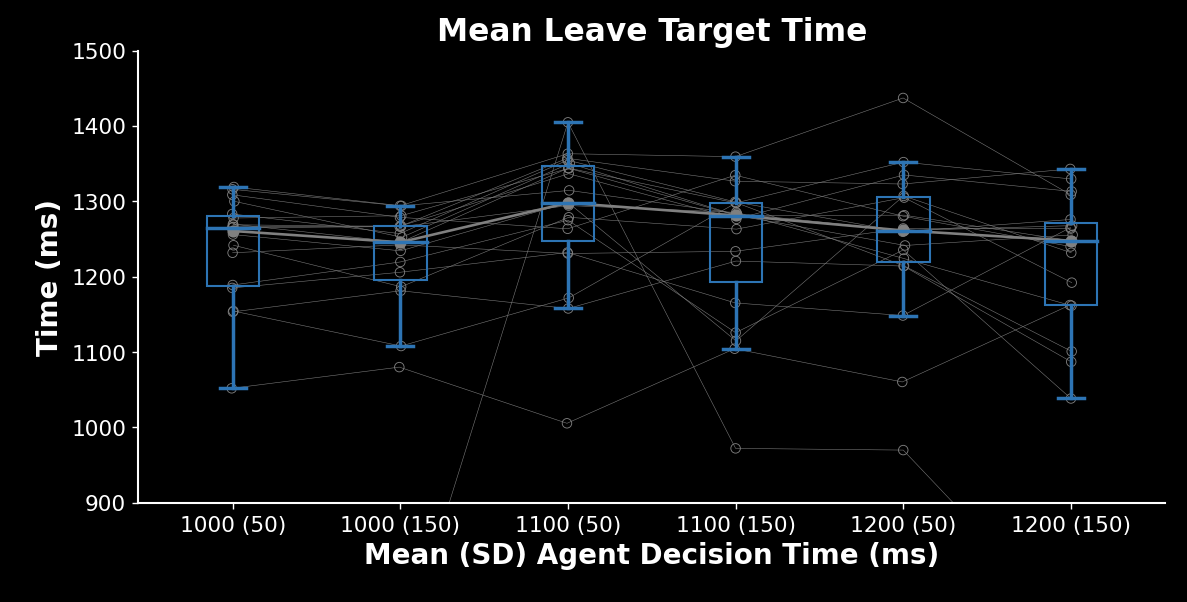

In [20]:
metric = group.combine_all_subjects('player_task_decision_time_mean') 
optimal_metric = group_model.wtd_optimal_leave_target_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Mean Leave Target Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

Player Minus Agent Mean Leave Target Time

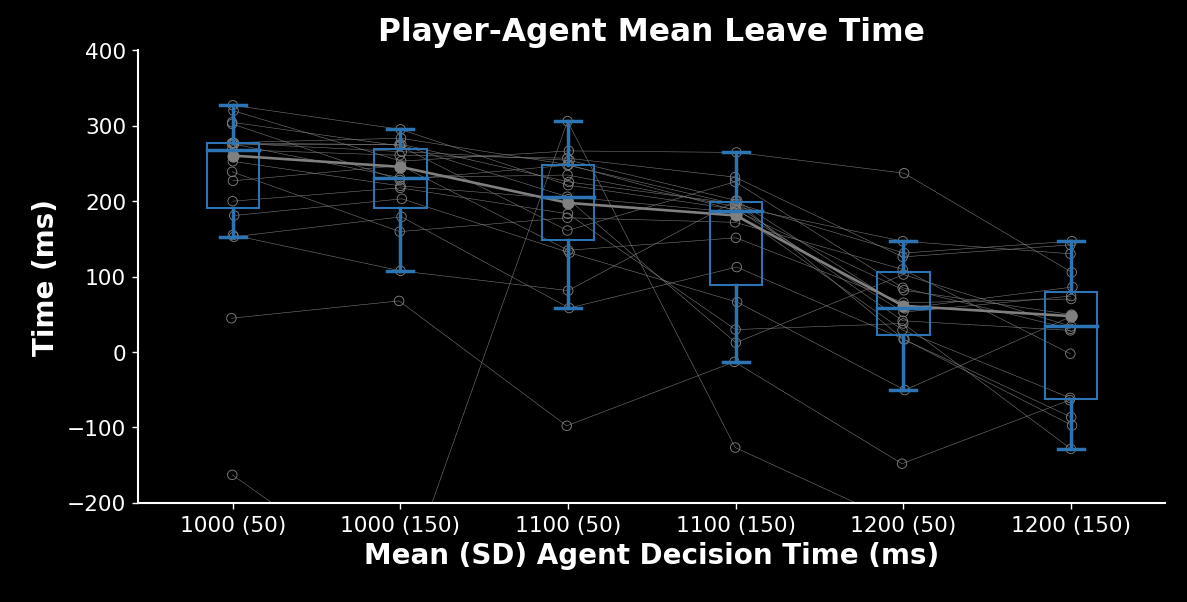

In [21]:
metric = group.combine_all_subjects('player_minus_agent_task_decision_time_mean') 
optimal_metric = group_model.player_minus_agent_leave_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(-200,500,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Player-Agent Mean Leave Time')
if save:
    axmain.set_axis_off()
    # plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

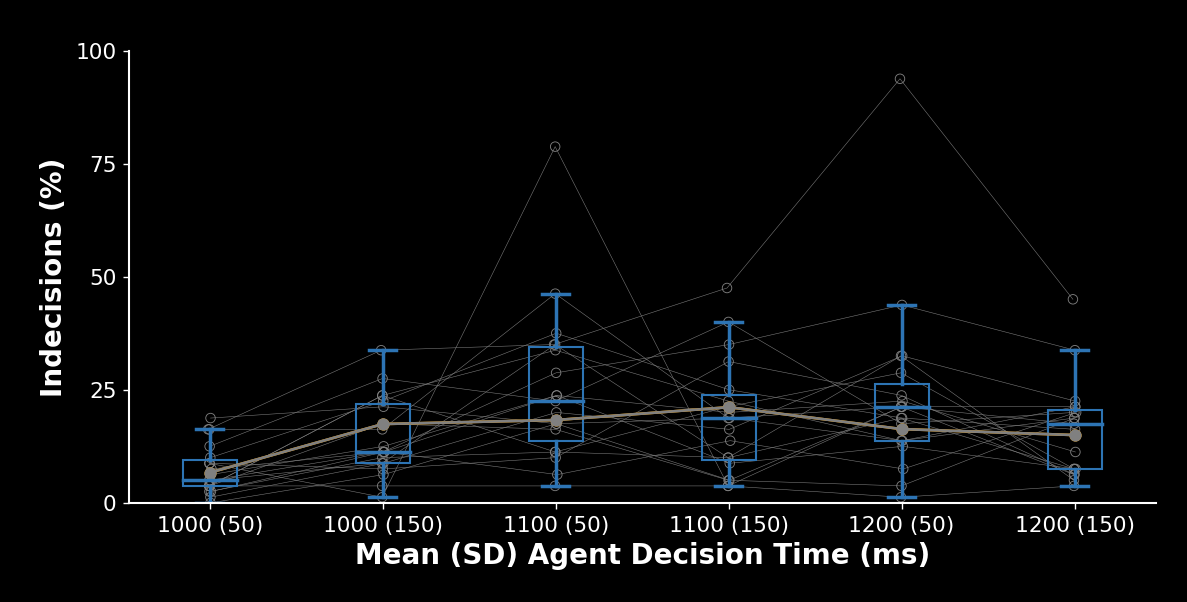

In [22]:
metric = group.combine_all_subjects('player_perc_indecisions') 
optimal_metric = group_model.prob_indecision_optimal*100
optimal_metric_calc = group_model.perc_indecision_calc

# optimal_metric = group_model.prob_indecision_based_on_reach_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Indecisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions_with_optimal_model', dpi = 400, transparent = True)
    
axmain.set_axis_off()

plt.show()

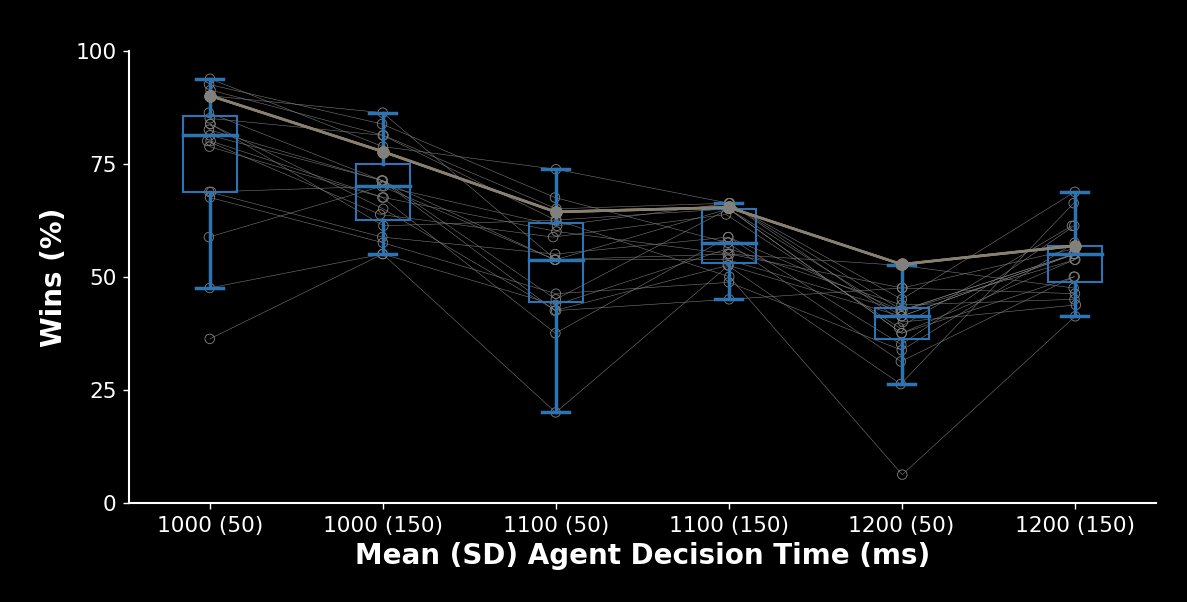

In [23]:
metric = group.combine_all_subjects('player_perc_wins') 
optimal_metric = group_model.prob_win_optimal*100
optimal_metric_calc = group_model.perc_win_calc

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Wins (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

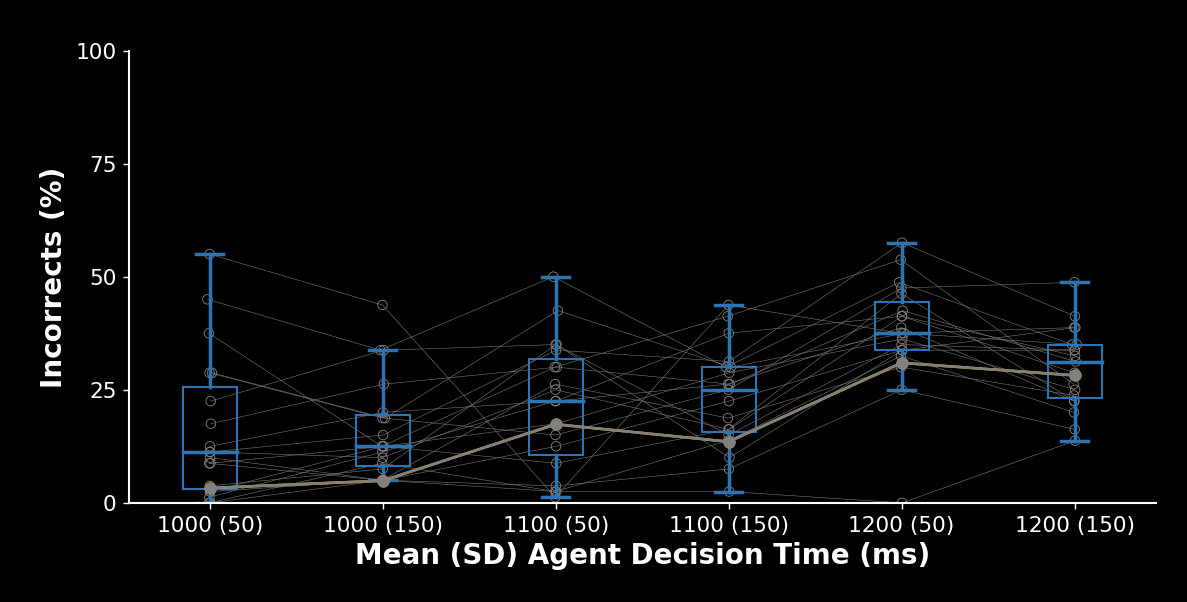

In [24]:
metric = group.combine_all_subjects('player_perc_incorrects') 
optimal_metric = group_model.prob_incorrect_optimal*100
optimal_metric_calc = group_model.perc_incorrect_calc

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Incorrects (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Gamble Decisions

In [25]:
optimal_metric1 = group_model.prob_selecting_reaction_optimal*100
optimal_metric2 = group_model.prob_selecting_gamble_optimal*100
data_metric1 = group.combine_all_subjects('perc_reactions')
data_metric2 = group.combine_all_subjects('perc_gambles')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction and Gamble Decisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

AttributeError: 'Subject' object has no attribute 'perc_reactions'

Reaction and Gamble Leave Times

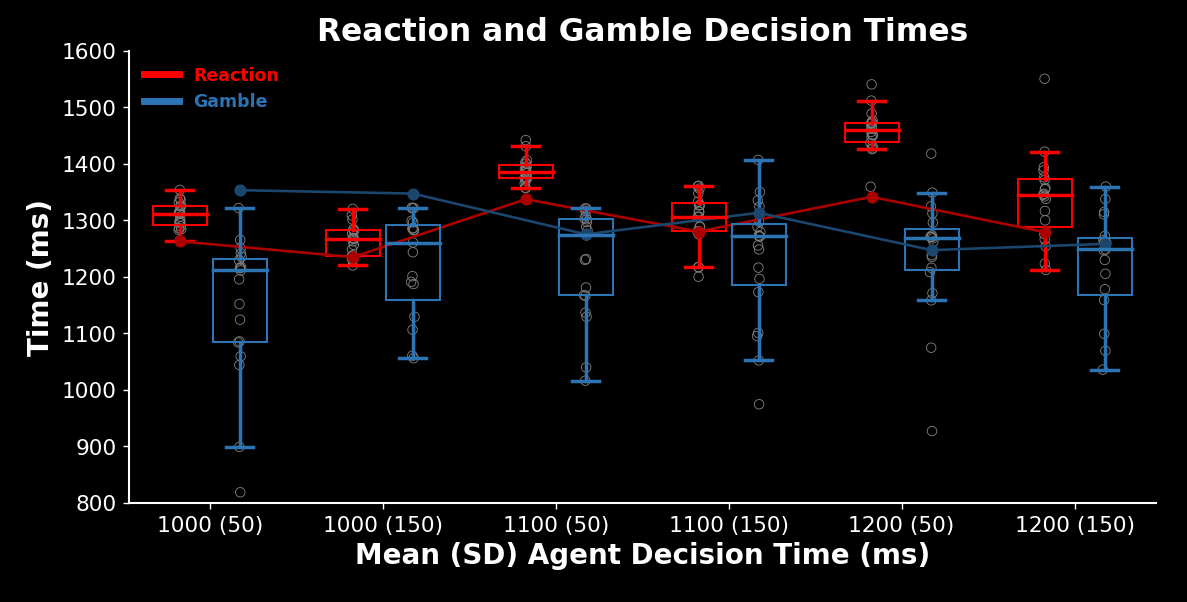

In [ ]:
optimal_metric1 = group_model.optimal_reaction_leave_target_time
optimal_metric2 = group_model.optimal_gamble_leave_target_time
data_metric1 = group.combine_all_subjects('reaction_decision_time_mean')
data_metric2 = group.combine_all_subjects('gamble_decision_time_mean')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(800,1700,100)


bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction and Gamble Decision Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decision_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Gambles

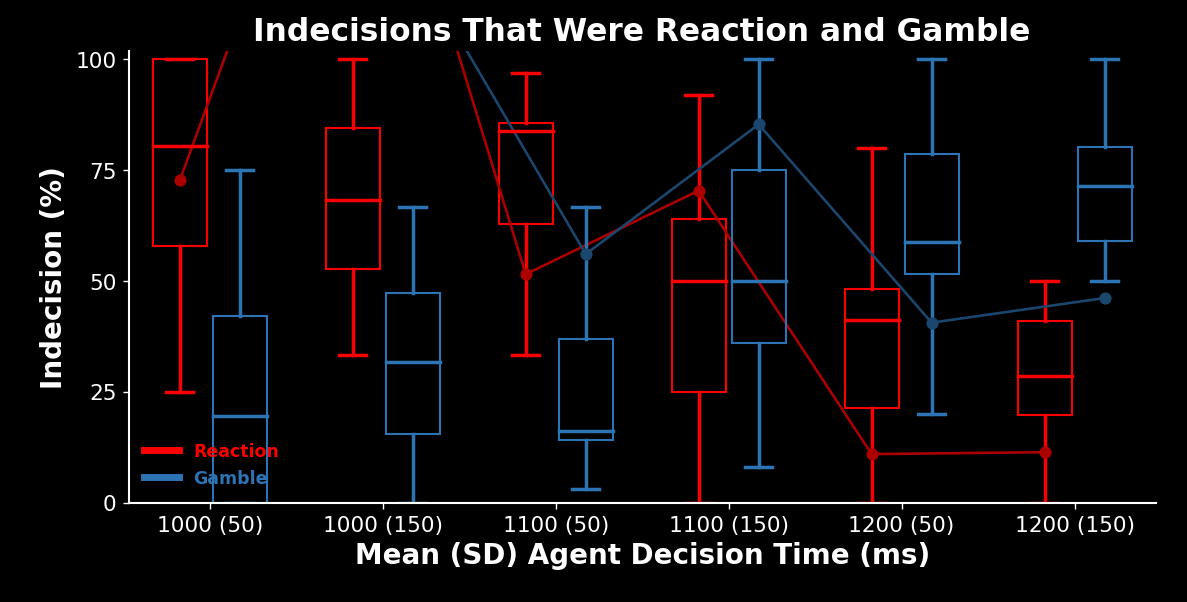

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_indecisions_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_indecisions_that_were_gambles') 
optimal_metric1 = group_model.perc_indecisions_that_were_reaction
optimal_metric2 = group_model.perc_indecisions_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Indecision (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Indecisions That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'reaction_and_gamble_indecisions', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

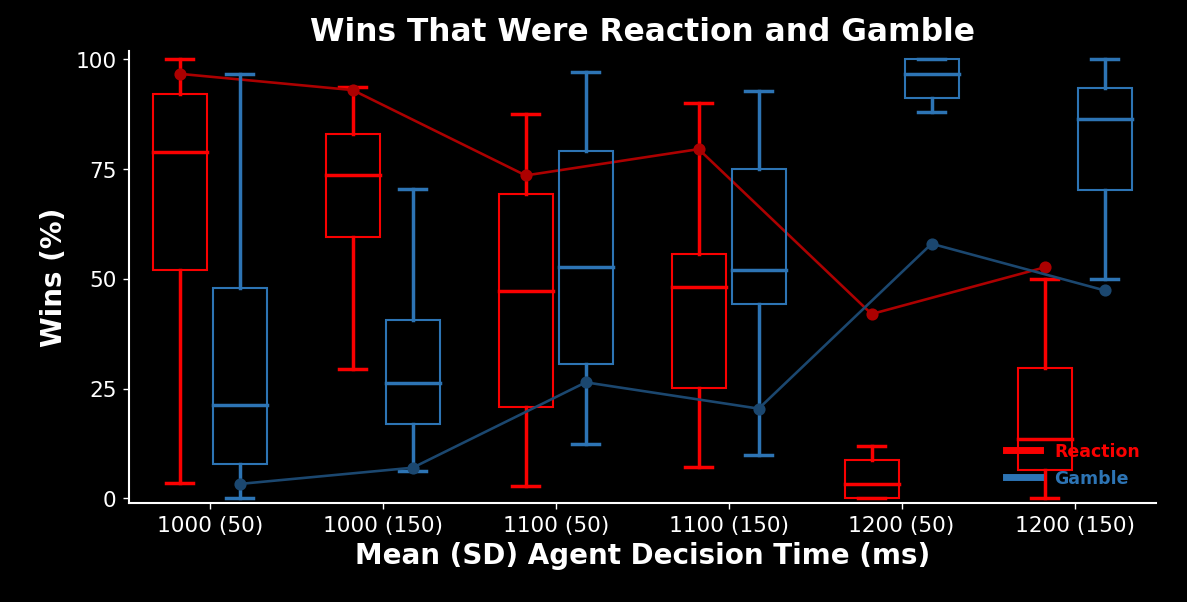

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_wins_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_wins_that_were_gambles') 
optimal_metric1 = group_model.perc_wins_that_were_reaction
optimal_metric2 = group_model.perc_wins_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Wins That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Incorrects that were reaction and gamble

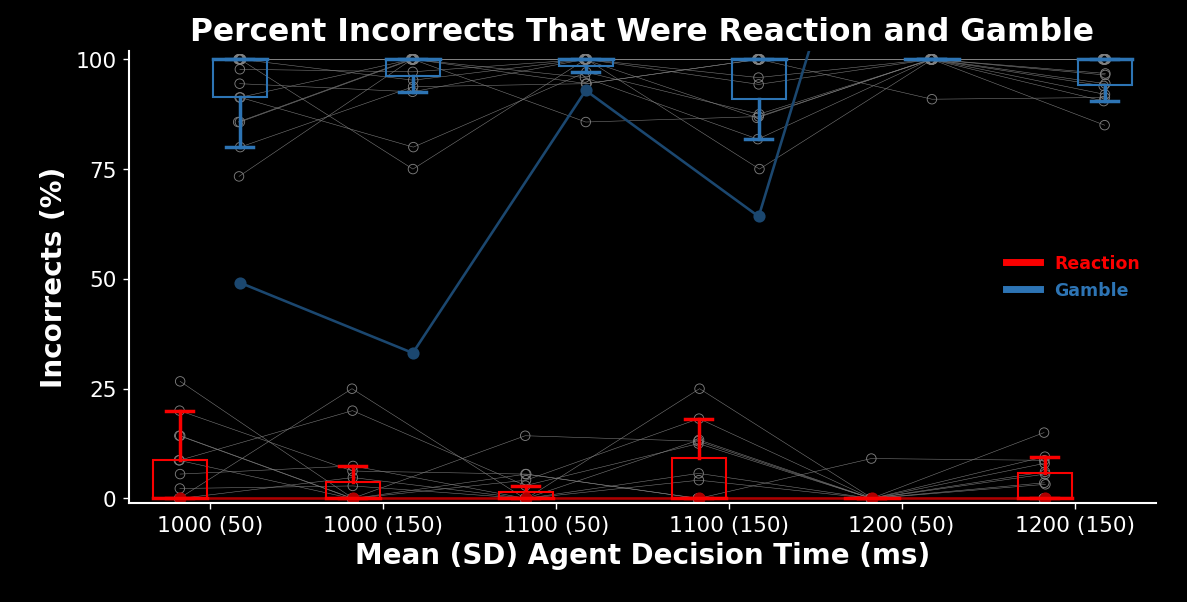

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_incorrects_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_incorrects_that_were_gambles') 
optimal_metric1 = group_model.perc_incorrects_that_were_reaction
optimal_metric2 = group_model.perc_incorrects_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Incorrects (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Percent Incorrects That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win

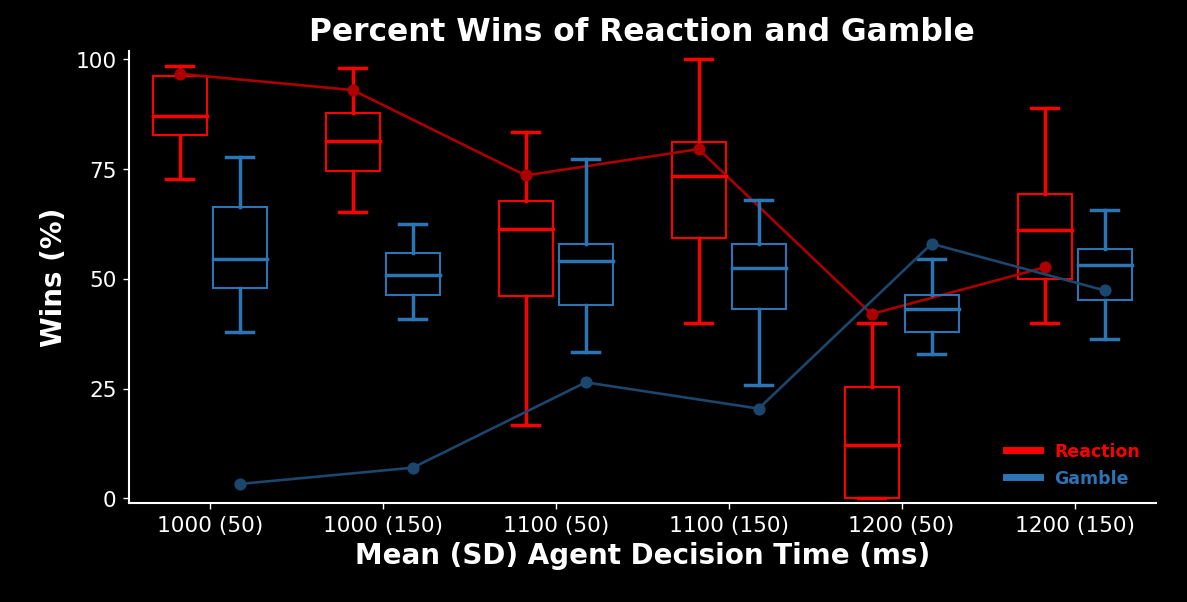

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were wins
metric1 = group.combine_all_subjects('perc_reaction_wins') 
metric2 = group.combine_all_subjects('perc_gamble_wins') 
optimal_metric1 = group_model.perc_wins_that_were_reaction
optimal_metric2 = group_model.perc_wins_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Percent Wins of Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Indecisions of Reaction and Gamble

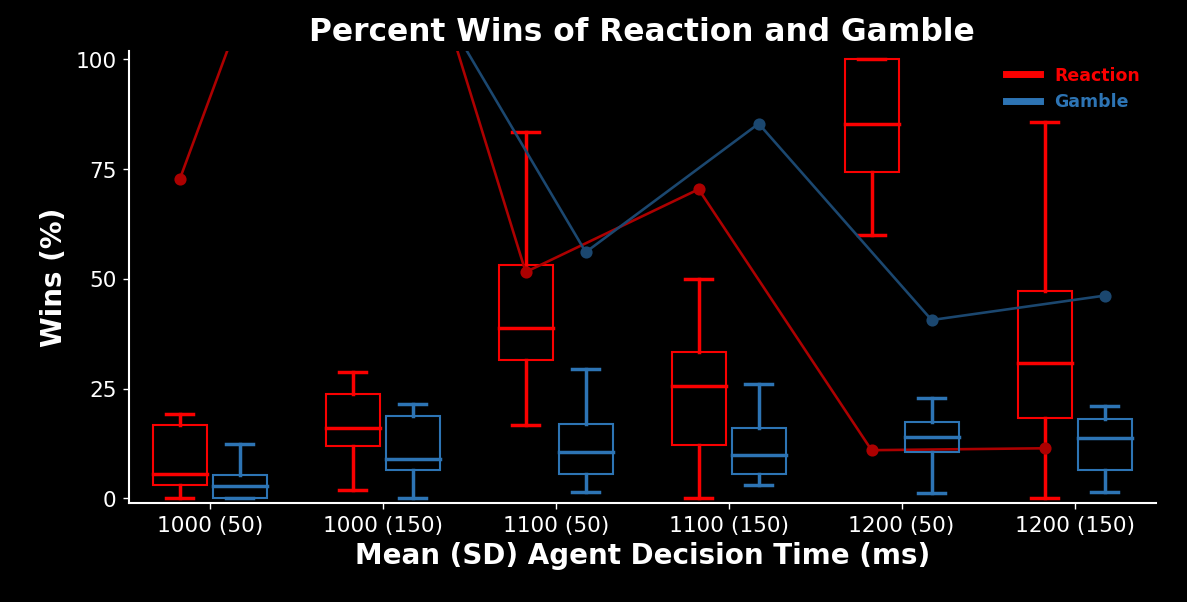

In [ ]:
#!!!!!!!!!!!! Out of x number of reaction and gamble decisions, how many of them were indecisions!!!!!!!
metric1 = group.combine_all_subjects('perc_reaction_indecisions') 
metric2 = group.combine_all_subjects('perc_gamble_indecisions') 
optimal_metric1 = group_model.perc_indecisions_that_were_reaction
optimal_metric2 = group_model.perc_indecisions_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Percent Wins of Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()